# Linear Image Filters

---
## 1. Box Filter

A box filter is a simple low-pass filter that uses a box as the kernel. Intuitively, the filter just averages the pixel values in a local $k \times k$ neighborhood, therefore creating a blurring effect.

Mathmatically, a box filter is defined as:

$$
H[m,n] = \frac{1}{k^2}, \quad 0 \leq m,n < k
$$


Basically the kernel is just a **matrix of ones** normalized by the number of elements.
For example, for $k=3$:

$$
h = \frac{1}{9}
\begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{bmatrix}
$$

When you apply this filter to an image $f[i,j]$:

$$
g[i,j] = \sum_{m=-(k-1)/2}^{(k-1)/2} \sum_{n=-(k-1)/2}^{(k-1)/2}
h[m,n] \cdot f[i-m, j-n]
$$

Since every $h[m,n] = \tfrac{1}{k^2}$:

$$
g[i,j] = \frac{1}{k^2} \sum_{m=-(k-1)/2}^{(k-1)/2} \sum_{n=-(k-1)/2}^{(k-1)/2} f[i-m, j-n]
$$

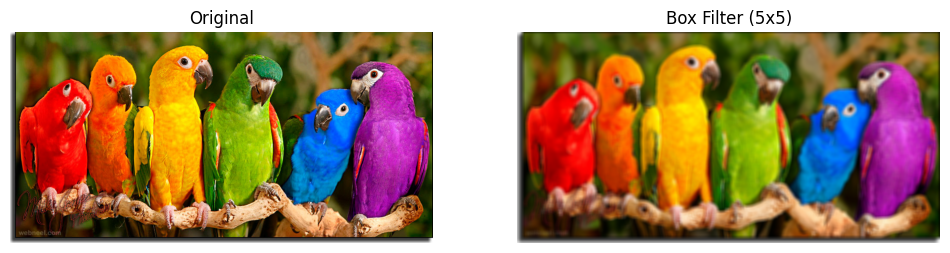

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def box_filter(size):
    """Create a normalized 2D box filter of given size."""
    return np.ones((size, size), dtype=np.float32) / (size * size)


def convolve2d(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """Apply 2D convolution between an image and a kernel (without padding)."""
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape
    pad_h = kernel_h // 2
    pad_w = kernel_w // 2

    # Pad the image
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')

    # Output image
    result = np.zeros_like(image)

    for i in range(image_h):
        for j in range(image_w):
            region = padded[i:i+kernel_h, j:j+kernel_w]
            result[i, j] = np.sum(region * kernel)

    return result


img = Image.open("../img/parrots.jpg").convert("RGB")
img_np = np.array(img, dtype=np.float32)

# Define box filter of size 5x5
kernel = box_filter(10)

# Apply box filter to each channel separately
blurred_channels = []
for c in range(3):  # R, G, B
    channel = img_np[:, :, c]
    blurred_c = convolve2d(channel, kernel)
    blurred_channels.append(blurred_c)

# Stack channels back into an image
blurred_img = np.stack(blurred_channels, axis=2).astype(np.uint8)

# Display results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_np.astype(np.uint8))
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(blurred_img)
axes[1].set_title("Box Filter (10x10)")
axes[1].axis("off")

plt.show()

---
## 2. Guassian Filter
Guassian filter is one of the most important, if not the most important filter in computer vision. It is a good model for many naturally occurring filters.

It is defined as:
$$
G(i, j) = \frac{1}{2\pi\sigma^2} \; e^{\left(-\frac{i^2 + j^2}{2\sigma^2}\right)}
$$

Therefore applied the kernel to a discrete image (as a function of $f$) at pixel $(i, j)$ results in:
$$
g[i, j] = \frac{1}{2\pi\sigma^2} \sum_{m=1}^{K} \sum_{n=1}^{K} \; e^{\left(-\frac{m^2 + n^2}{2\sigma^2}\right)} f[i-m, j-n]
$$

---
### 2.1. What Does a Guassian Filter Look Like?
Before we apply the filter to an actual image, let's first visualize what a Guassian kernel is.

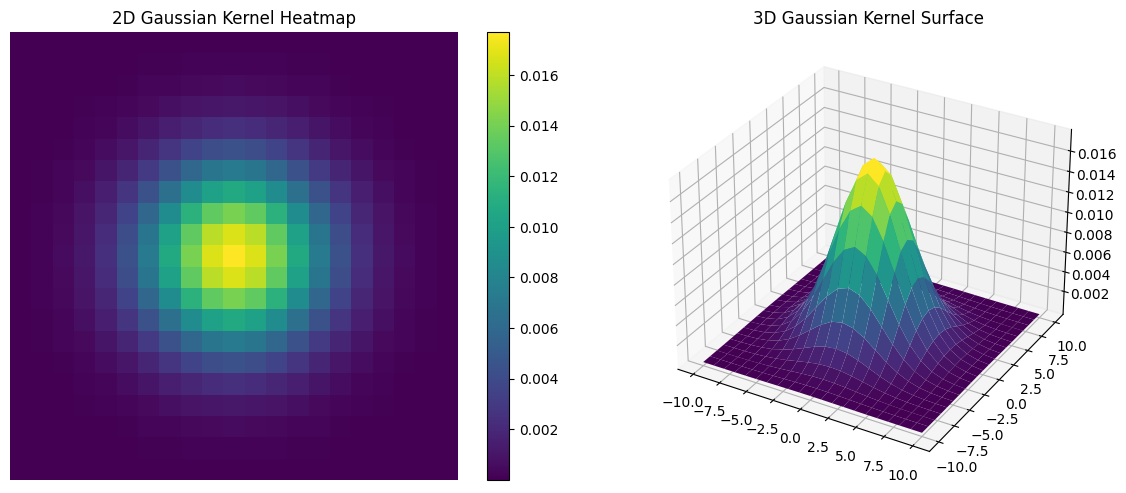

In [11]:

"""Generate a (size x size) Gaussian kernel."""
def gaussian_kernel(size: int, sigma: float) -> np.ndarray:
    # Creates a 1D array of size values evenly spaced between -size//2 and size//2
    # Example: size = 5 --> array([-2., -1.,  0.,  1.,  2.])
    ax = np.linspace(
        start=-(size // 2), 
        stop=size // 2, 
        num=size)

    # Generates a 2D grid (like coordinate axes) from the 1D array:
    xx, yy = np.meshgrid(ax, ax)

    # Guassain formula: G(x, y) = e^-[(x^2 + y^2)/2(sigma)^2]
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))

    # Normalizes the kernel so the sum of all values is 1.
    return kernel / np.sum(kernel)


# Generate kernel
kernel = gaussian_kernel(size=21, sigma=3.0)

# Create a side-by-side plot
fig = plt.figure(figsize=(12, 5))

# Heatmap (2D)
ax1 = fig.add_subplot(1, 2, 1)
im = ax1.imshow(kernel, cmap='viridis')
fig.colorbar(im, ax=ax1)
ax1.set_title("2D Gaussian Kernel Heatmap")
ax1.axis('off')

# 3D surface plot
x = np.linspace(-(kernel.shape[0] // 2), kernel.shape[0] // 2, kernel.shape[0])
xx, yy = np.meshgrid(x, x)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(xx, yy, kernel, cmap='viridis')
ax2.set_title("3D Gaussian Kernel Surface")

plt.tight_layout()
plt.show()

---
### 2.2 The Impact of $\sigma$
There are two parameters in the function gaussian_kernel above: size and sigma. The size of the kernel indicates the blur radius, or how big the kernel is. And sigma indicates how "sharp" or "smooth" this kernel is. Let's take a closer look at the impact of sigma:

![Sigma effect on Guassian](../img/guassian_sigma.png)

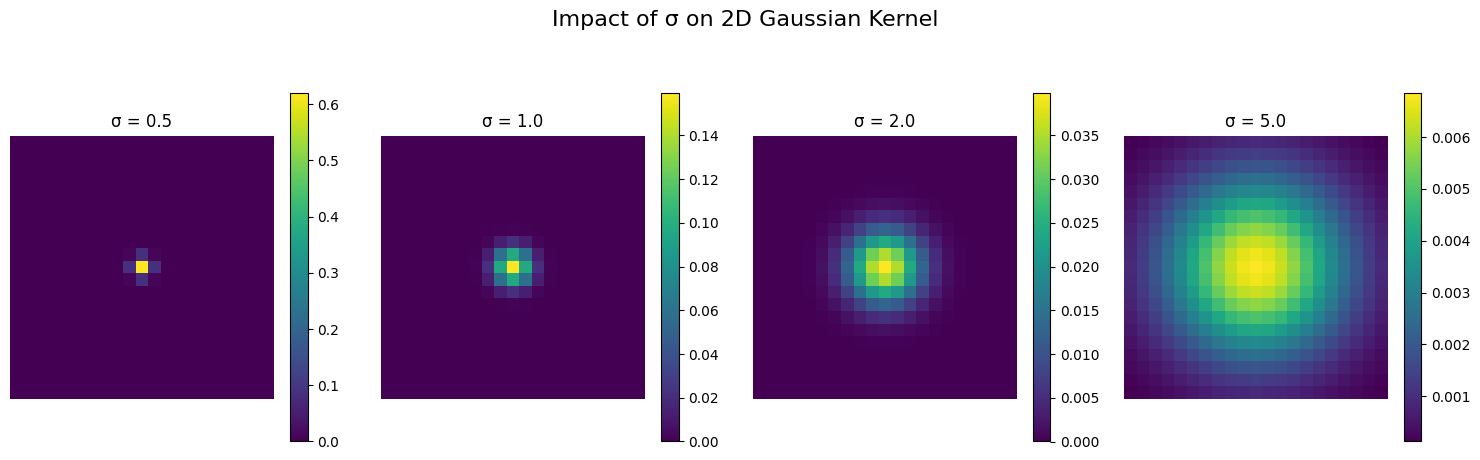

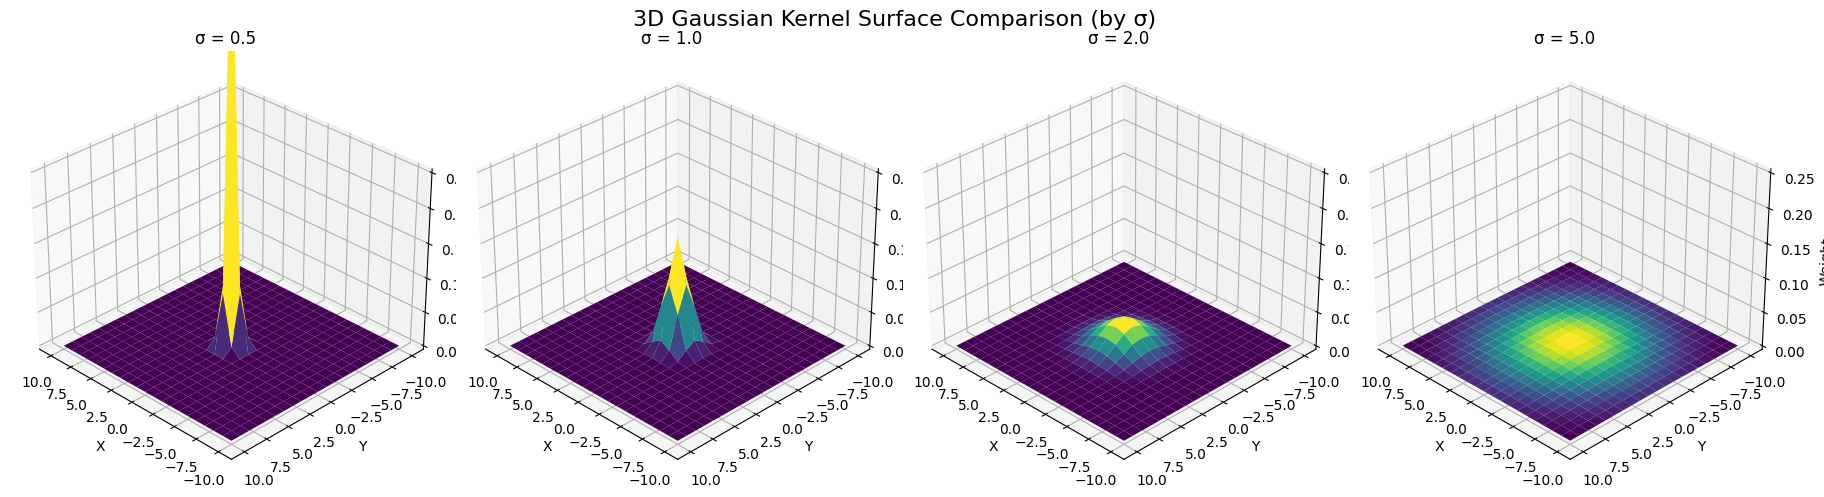

In [2]:
size = 21
sigmas = [0.5, 1.0, 2.0, 5.0]

# 2D Comparison
fig, axs = plt.subplots(1, len(sigmas), figsize=(15, 5))

for idx, sigma in enumerate(sigmas):
    kernel = gaussian_kernel(size, sigma)
    im = axs[idx].imshow(kernel, cmap='viridis')
    axs[idx].set_title(f"σ = {sigma}")
    axs[idx].axis('off')
    fig.colorbar(im, ax=axs[idx], shrink=0.8)

plt.suptitle("Impact of σ on 2D Gaussian Kernel", fontsize=16)
plt.tight_layout()
plt.show()


# 3D Comparison
fig = plt.figure(figsize=(18, 5))

for idx, sigma in enumerate(sigmas):
    kernel = gaussian_kernel(size, sigma)
    ax = fig.add_subplot(1, len(sigmas), idx + 1, projection='3d')
    ax.plot_surface(xx, yy, kernel, cmap='viridis')
    ax.set_title(f'σ = {sigma}', fontsize=12)
    ax.set_zlim(0, 0.25)
    ax.view_init(elev=30, azim=135)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Weight')

plt.suptitle("3D Gaussian Kernel Surface Comparison (by σ)", fontsize=16)
plt.tight_layout()
plt.show()

---
### 2.3 Applying the Gaussian Filter
Now let's apply the Gaussian filter to an actual image to see the effects (with different $\sigma$ values)

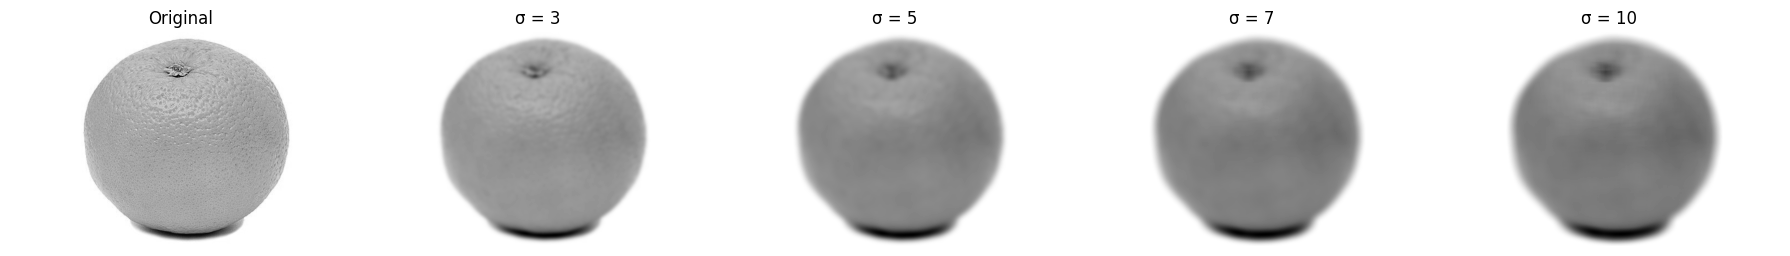

In [ ]:
from PIL import Image


# Load and convert image to grayscale
img = Image.open("../img/orange.jpeg").convert("L")  # L = grayscale
img_np = np.array(img, dtype=np.float32)
size = 21

# Display original image
fig, axes = plt.subplots(1, 5, figsize=(18, 5))
axes[0].imshow(img_np, cmap='gray')
axes[0].set_title("Original")
axes[0].axis("off")

# Try different sigma values
for index, sigma in enumerate([3, 5, 7, 10]):
    # Define the kernel
    kernel = gaussian_kernel(size=size, sigma=sigma)

    # Apply convolution
    blurred = convolve2d(img_np, kernel)

    # Display the blurred image
    axes[index + 1].imshow(blurred, cmap='gray')
    axes[index + 1].set_title(f"σ = {sigma}")
    axes[index + 1].axis("off")

plt.tight_layout()
plt.show()


---
### 2.4 Optimization

Notice how it took a little bit to run for the code above? It turns out there is a faster way to calculate convolution!

Let's re-examine the guassian formula as following:
$$
g[i, j] = \frac{1}{2\pi\sigma^2} \sum_{m=1}^{K} \sum_{n=1}^{K} \; e^{\left(-\frac{m^2 + n^2}{2\sigma^2}\right)} f[i-m, j-n]
$$
we can actually separate the the exponent  $e^{\left(-\frac{m^2 + n^2}{2\sigma^2}\right)}$ into $e^{\left(-\frac{m^2}{2\sigma^2}\right)}$ and $e^{\left(-\frac{n^2}{2\sigma^2}\right)}$. Therefore $g[i, j]$ can be re-written as following:

$$
g[i, j] = \frac{1}{2\pi\sigma^2} \sum_{m=1}^{K} \; e^{\left(-\frac{m^2}{2\sigma^2}\right)} \cdot \sum_{n=1}^{K} \; e^{\left(-\frac{n^2}{2\sigma^2}\right)} f[i-m, j-n]
$$

This shows the 2D convolution is equivalent to:
1. Convolve the image horizontally with a 1D Gaussian in n(or x direction).
2. Convolve the result vertically with a 1D Gaussian in m(or y direction)

Let's now compare the runtime between two different approaches!

Size=21  Sigma=10  Method=1D Convolution  Runtime=0.04 seconds
Size=21  Sigma=10  Method=2D Convolution  Runtime=2.23 seconds


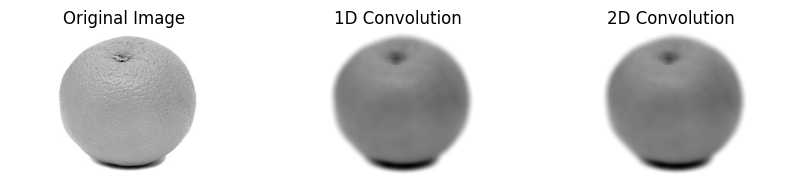

In [10]:
def gaussian_kernel_1d(size: int, sigma: float) -> np.ndarray:
    """Generate a normalized 1D Gaussian kernel."""
    ax = np.arange(-(size // 2), size // 2 + 1)
    kernel = np.exp(-0.5 * (ax / sigma) ** 2)
    kernel /= np.sum(kernel)
    return kernel.astype(np.float32)


def convolve1d(image: np.ndarray, kernel: np.ndarray, axis: int) -> np.ndarray:
    """
    Perform 1D convolution along a specific axis (0 for rows, 1 for columns).
    Pads the image with edge values.
    """
    k_len = kernel.shape[0]
    pad = k_len // 2

    # Pad along the chosen axis
    if axis == 0:  # vertical
        padded = np.pad(image, ((pad, pad), (0, 0)), mode='edge')
    else:          # horizontal
        padded = np.pad(image, ((0, 0), (pad, pad)), mode='edge')

    result = np.zeros_like(image, dtype=np.float32)

    # Convolution
    if axis == 0:  # vertical
        for i in range(image.shape[0]):
            region = padded[i:i+k_len, :]         # shape (k_len, width)
            # Weighted sum across rows -> shape (width,)
            result[i, :] = np.sum(region * kernel[:, None], axis=0)
    else:          # horizontal
        for j in range(image.shape[1]):
            region = padded[:, j:j+k_len]         # shape (height, k_len)
            # Weighted sum across cols -> shape (height,)
            result[:, j] = np.sum(region * kernel[None, :], axis=1)

    return result


import time

sizes = [21]
sigmas = [10]

for size, sigma in zip(sizes, sigmas):
    kernel_1d = gaussian_kernel_1d(size=size, sigma=sigma)
    kernel_2d = gaussian_kernel(size=size, sigma=sigma)

    start = time.time()
    temp = convolve1d(img_np, kernel_1d, axis=0)
    blurred_1d = convolve1d(temp, kernel_1d, axis=1)
    end = time.time()
    print(f"Size={size}  Sigma={sigma}  Method=1D Convolution  Runtime={end - start:.2f} seconds")

    start = time.time()
    blurred_2d = convolve2d(img_np, kernel_2d)
    end = time.time()
    print(f"Size={size}  Sigma={sigma}  Method=2D Convolution  Runtime={end - start:.2f} seconds")

    # Display original and blurred images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img_np, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(blurred_1d, cmap='gray')
    plt.title(f"1D Convolution")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(blurred_2d, cmap='gray')
    plt.title(f"2D Convolution")
    plt.axis('off')
    plt.show()


It turns out that:

* The runtime for naive 2D convolution with kernel size $K \times K$ is $\mathcal{O}(K^2 \cdot N)$, where $N$ = number of pixels.

* The runtime for 2 1D convolutions is $\mathcal{O}(K \cdot N)$ for convolving vertically, then $\mathcal{O}(K \cdot N)$ for convolving horizontally. Total = $\mathcal{O}(2KN)$, which is a lot faster!